# Simulating Language 13, Iterated Learning (lab) (some answers)

The simulation we'll build in this notebook explores the cultural evolution of a signalling system in a population of agents. In particular, we’ll look at the effects on communicative accuracy of:
- different learning biases (weight update rules),
- different ways of communicating,
- different populations models

There's a lot in this lab, so it's probably worth having a play with the simulation runs first before going back and understanding the code. However, make sure you understand what the new parameters do first!

First, we'll most of the code from the last lab. (We're going to replace the `learn` and `pop_produce` functions later on, so we're leaving them out).

In [1]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

def wta(items):
    maxweight = max(items)
    candidates = []
    for i in range(len(items)):
        if items[i] == maxweight:
            candidates.append(i)
    return random.choice(candidates)

def reception_weights(system, signal):
    weights = []
    for row in system:
        weights.append(row[signal])
    return weights

def communicate(speaker_system, hearer_system, meaning):
    speaker_signal = wta(speaker_system[meaning])
    hearer_meaning = wta(reception_weights(hearer_system, speaker_signal))
    if meaning == hearer_meaning: 
        return 1
    else: 
        return 0
    
def train(system, ms_pair_list):
    for pair in ms_pair_list:
        learn(system, pair[0], pair[1])

def pop_learn(population, data, no_learning_episodes):
    for n in range(no_learning_episodes):
        ms_pair = random.choice(data)
        learn(random.choice(population), ms_pair[0], ms_pair[1])

def ca_monte_pop(population, trials):
    total = 0.
    for n in range(trials):
        speaker = random.choice(population)
        hearer = random.choice(population)
        total += communicate(speaker, hearer, random.randrange(len(speaker)))
    return total / trials

The new part of our code starts with a set of parameter declarations; most of their meanings should all be straightforward by now. Note that the interactions parameter has two purposes in this simulation:
- to specify the number of utterances produced to create the data.
- to specify the number of times the data is randomly sampled in training.

We've added a parameter to control how the population is updated through iterated learning (see below), and one that specifies the type of the initial language. We've also added two slightly mysterious parameters. These both can be either `True` or `False`. If a variable takes one of these forms it can be used whenever you use an `if` in python. For example, this should print "yes, it is true!" out on the screen:

```python
x = True
if x:
    print('yes, it is true!')
```

`inhibition` controls whether learning involves "lateral inhibition", which we'll explain below. `communication` controls whether the sender tries to avoid signals that would be communicatively unsuccessful. We'll also see how this is done below.

In [2]:
meanings = 5                     # number of meanings
signals = 5                      # number of signals
interactions = 100               # both the number of utterances produced and the number
                                 # of times this set is randomly sampled for training.
size = 100                       # size of population
method = 'replacement'           # method of population update
initial_language_type = 'random' # either 'optimal' or 'random'
rule = [1, 0, 0, 0]              # learning rule (alpha, beta, gamma, delta)
inhibition = False               # apply lateral inhibition (can be True or False)
communication = False            # speaker tries to avoid ambiguity (can be True or False)

The function `new_agent` below creates a new agent. The weights in this agent’s network depend on the parameter `initial_language_type`. If this parameter is set to `random` (or in fact to anything other than `optimal`), every cell in the new agent’s signalling matrix is set initially to zero. If the `initial_language_type` parameter is set to `optimal`, then the weights are configured such that the agent’s initial weights ensure it signals optimally (`m1` is conveyed using `s1`, `m2` is conveyed using `s2`, etc). The function `new_population` then uses the `new_agent` function to create a population of new agents.

In [3]:
def new_agent(initial_language_type):
    system = []
    for row_n in range(meanings):
        row = []
        for column_n in range(signals):
            if initial_language_type == 'optimal' and row_n == column_n:
                row.append(1)
            else:
                row.append(0)
        system.append(row)
    return system

def new_population(size, initial_language_type):
    population = []
    for i in range(size):
        population.append(new_agent(initial_language_type))
    return population

## Lateral inhibition in learning

This is a slightly more complicated learning function compared to what we had before. Now, instead of just counting the number of times an agent sees a meaning with a signal, the association weights between all the (wrong) signals that are associated with that meaning can be reduced, and all the (wrong) meanings that are associated with that signal can be reduced. This is called "lateral inhibition" in that all the associations sideways along the rows and columns are inhibited each time a pair is strengthened. If `inhibition` is `False` then `learn` works just as before.

In [4]:
def learn(system, meaning, signal):
    system[meaning][signal] += 1
    if inhibition:
        for m in range(len(system)):
            for s in range(len(system[m])):
                if (m != meaning and s == signal) or (m == meaning and s != signal):
                    system[m][s] -= 1

## Communicatively rational speakers

So far in this course, speakers haven't "tried" to be communicative. They have simply produced what their signalling matrix told them to. But a more rational speaker would not blindly produce a signal if it is going to be misunderstood. How could a speaker know that they are going to be misunderstood if they don't know what the hearer has in their signalling matrix? One way is to assume that the hearer is like them and imagine what *they* would understand if they heard a given signal. This what the following code does. If `communication` is `True` then the speaker checks whether the signal they are about to produce would allow them themselves to understand the right meaning. If it doesn't they just try a random other signal instead. If `communication` is `False`, then it works exactly as before.

In [5]:
def produce(speaker, meaning):
    signal = wta(speaker[meaning])
    if communication:
        speaker_meaning = wta(reception_weights(speaker, signal))
        if (meaning != speaker_meaning):
            signal = random.randrange(len(speaker[0]))
    return signal

def pop_produce(population, no_productions):
    ms_pairs = []
    for n in range(no_productions):
        speaker = random.choice(population)     
        meaning = random.randrange(len(speaker))
        signal = produce(speaker, meaning)
        ms_pairs.append([meaning, signal])
    return ms_pairs

*Try out the `produce` function with different speaker matrices and meanings to make sure it behaves as you would expect when you use a matrix that has homonymy in it when you change the `communication` parameter. (Hint: even when the speaker is being communicatively helpful, they may still use an unhelpful signal by chance, so you might have to run `produce` thousands of times and count the results to see the difference in practice. If you sit down with a piece of paper and a pen, you could even come up with a prediction of exactly how much better the communicatively rational speaker should be for a given signalling matrix!)*

In [6]:
speaker = [[1, 1], [0, 2]]

communication = False
bad_signal_count = 0
for i in range(1000):
    if produce(speaker, 0) == 1:
        bad_signal_count += 1
print(bad_signal_count / 1000)

communication = True
bad_signal_count = 0
for i in range(1000):
    if produce(speaker, 0) == 1:
        bad_signal_count += 1
print(bad_signal_count / 1000)

0.498
0.241


## The Simulation

In [7]:
def simulation(generations, mc_trials, report_every):
    population = new_population(size, initial_language_type)
    data_accumulator = []
    for i in range(generations + 1):
        if (i % report_every == 0):
            data_accumulator.append(ca_monte_pop(population, mc_trials))
        data = pop_produce(population, interactions)
        if method == 'chain':
            population = new_population(size, 'random')
            pop_learn(population, data, interactions)
        if method == 'replacement':
            population = population[1:]
            learner = new_agent('random')
            pop_learn([learner], data, interactions)
            population.append(learner)
        if method == 'closed':
            pop_learn(population, data, interactions)
    return [population, data_accumulator]

The simulation function runs the simulation. It takes three parameters, as follows:
- `generations`: the number of generations in the simulation
- `mc_trials`: the number of trials used to calculate communicative accuracy 
- `report_every`: the frequency with which data points (for printing in a graph) are returned

It then runs through the following steps:
1. Initialise the population
2. For each generation:
    1. Evaluate the population’s communicative accuracy
    2. Produce some data
    3. Update the population (by adding new agents)
    4. Get (some of) the new population to learn from the data produced in 2A.
3. Output the final state of the population, and the list of communicative accuracy scores

The parameter `method` defines exactly how the population is updated, based on the scheme outlined by Mesoudi & Whiten:
- `chain`: create a completely new population
- `replacement`: remove one agent from the population, and replace with a new agent
- `closed`: do not change the population at all

There are two things to note about the Python code in this function.

### Review: slicing a list

The slice `[start : end]` operator allows us to take a slice of sequential elements between start and end from a list.
As usual in Python, the sequence extracts starts at start, and continues up to, but not including, end. Either the start or end (or both) indexes can be omitted, in which case the start or end of the list is assumed, respectively.

For example, try the following:

```python
x = ['a', 'b', 'c', 'd']
print(x[1:])
print(x[:3])
```

In [8]:
x = ['a', 'b', 'c', 'd']
print(x[1:])
print(x[:3])

['b', 'c', 'd']
['a', 'b', 'c']


### Modulus (remainder)

The `x % y` operator returns the remainder of the division of x by y.

For example, `7 % 3` gives us `1`, `11 % 4` gives us `3`, and `10 % 2` gives us `0`.

In the `simulation` function, the modulus operator is used to decide whether or not to calculate the value of `ca_monte_pop` and output it for the graphs. Can you see how it works? (We do this because calculating the communicative accuracy actually takes quite a bit of time, so we don't want to slow it down too much!)

## Questions

Everyone should try questions 1-4. Question 5 is more open-ended, and needn’t involve coding (but could).

1. Run the simulation for 500 generations, with 1000 mc_trials per generation, outputting communicative accuracy every 10 generations. Plot the values on a graph. (Hint: be careful with your x-axis. Are you sure you understand what it means!)

Text(0,0.5,'communicative accuracy')

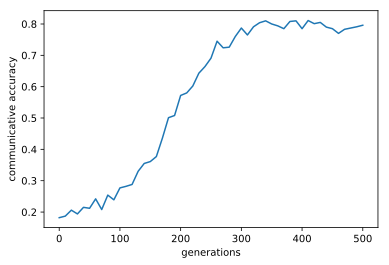

In [9]:
inhibition = False
communication = False
plt.plot(range(0, 501, 10),simulation(500, 1000, 10)[1])
plt.xlabel('generations')
plt.ylabel('communicative accuracy')

2. Experiment with turning on and off lateral inhibition and communicatively rational speakers (by changing the `inhibition` and `communication` parameters to `True`). Which combinations construct perfect construct perfect communicative systems from random languages?

In [10]:
inhibition = False
communication = False
results_noi_nor = []
for i in range(50):
    results_noi_nor.append(simulation(500, 1000, 10)[1])

inhibition = True
communication = False
results_i_nor = []
for i in range(50):
    results_i_nor.append(simulation(500, 1000, 10)[1])

inhibition = False
communication = True
results_noi_r = []
for i in range(50):
    results_noi_r.append(simulation(500, 1000, 10)[1])

inhibition = True
communication = True
results_i_r = []
for i in range(50):
    results_i_r.append(simulation(500, 1000, 10)[1])


[Text(0.5,0,'communicative accuracy')]

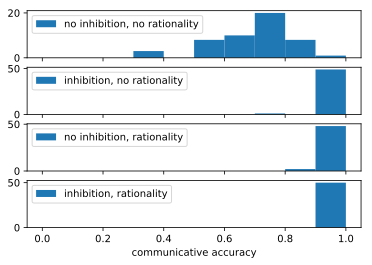

In [14]:
def final_results(results):
    final = []
    for r in results:
        final.append(r[len(r)-1])
    return final

fig, axs = plt.subplots(nrows=4, ncols=1, sharex='all')

ax = axs[0]
ax.hist(final_results(results_noi_nor), range=(0,1), bins=10, label='no inhibition, no rationality')
ax.legend()

ax = axs[1]
ax.hist(final_results(results_i_nor), range=(0,1), bins=10, label='inhibition, no rationality')
ax.legend()

ax = axs[2]
ax.hist(final_results(results_noi_r), range=(0,1), bins=10, label='no inhibition, rationality')
ax.legend()

ax = axs[3]
ax.hist(final_results(results_i_r), range=(0,1), bins=10, label='inhibition, rationality')
ax.legend()

ax.set(xlabel='communicative accuracy')

3. Change the population update method to ‘chain’, and re-run the simulation. What happens? Why? Increase the number of interactions by a factor of 100, and reduce the number of generations by a factor of 10. What happens now?
4. Experiment with the ‘closed’ method as well. What difference does the update method make to the way the simulation works?
5. In previous worksheets you have had the opportunity to write and play with code which models genetic transmission, spatial organisation, and so on. How would you fit these things in to this iterated learning model? Why might that be an interesting thing to do?

## Example answer for assessment 1

In [15]:
def produce(speaker, meaning):
    signal = wta(speaker[meaning])
    if communication:
        speaker_meaning = wta(reception_weights(speaker, signal))
        if meaning != speaker_meaning:
            if super_rational:
                good_signals = []
                for s in range(len(speaker[0])):
                    speaker_meaning = wta(reception_weights(speaker, s))
                    if meaning == speaker_meaning:
                        good_signals.append(s)
                    if good_signals != []:
                        signal = random.choice(good_signals)
            else:
                signal = random.randrange(len(speaker[0]))
    return signal

In [16]:
inhibition = False
communication = True
super_rational = False
results1=[]
for i in range(100):
    result = simulation(500,1000,10)[1]
    results1.append(result)

In [17]:
super_rational = True
results2=[]
for i in range(100):
    result = simulation(500,1000,10)[1]
    results2.append(result)

In [18]:
def average_results(results):
    average=[]
    for i in range(len(results[0])):
        total = 0
        for r in results:
            total += r[i]
        total /= len(results)
        average.append(total)
    return average

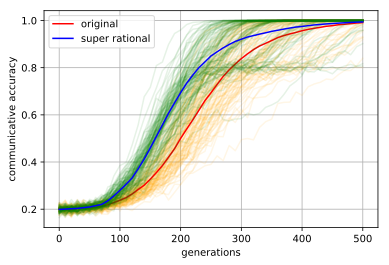

In [19]:
for r in results1:
    plt.plot(range(0, 501, 10),r, color='orange', alpha =0.1)

plt.plot(range(0, 501, 10),average_results(results1), color='red', label='original')
    
for r in results2:
    plt.plot(range(0, 501, 10),r, color='green', alpha =0.1)

plt.plot(range(0, 501, 10),average_results(results2), color='blue', label='super rational')
    
plt.legend()
plt.xlabel('generations')
plt.ylabel('communicative accuracy')
plt.grid()
plt.savefig('super_rational.pdf')